CEO-Request Challenge

Problem statement (summarized)

How should Olist improve it's profit margin, given that it has
- revenues per sellers per months
- revenues per orders
- reputation costs (estimated) per bad reviews
- operational costs of IT system that grows with number of orders, but not linearly (scale effects)

Unit Economics
Revenue

Olist takes a 10% cut on the product price (excl. freight) of each order delivered.
Olist charges 80 BRL by month per seller.
Cost

In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
review_score	cost (BRL)
1 star	100
2 stars	50
3 stars	40
4 stars	0
5 stars	0
In addition, Olist’s IT costs (servers, etc…) increase with the amount of orders processed, albeit less and less rapidly (scale effects).
For the sake of simplicity, we will consider Olist’s total cumulated IT Costs to be proportional to the square-root of the total cumulated number of orders approved.
The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

We advise you to start with the following analysis

🕵🏻 **Should Olist remove underperforming sellers from its marketplace ?**

To analyse the impact of removing the worse sellers from Olist's marketplace, we will perform a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? (granted, it's hard to know in advance who is a good seller, but let's start with this and iterate later).

1️⃣ Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ We can then:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform. 
- we may find an optimal number of sellers to remove that maximizes Olist's profit margin

👉 Write down a detailed strategy (step by step) to create the DataFrame you need for the first step.

💡Think about how to re-use or update the logic you've already coded in your 🗂 `olist` package

<details>
    <summary>- <i>Hints</i> -</summary>


Starting from your current `seller().get_training_data()` DataFrame, can you easily transform it to compute:
- Olist's positive `revenue_per_seller`? 
- Olist's `cost_of_bad_reviews`?

⚠️ Do no start from scratch ! Investigate your source code in `seller.py` : 

</details>


Revenues_per_seller = sales
cost_of_bad_reviews = calculate cost of each review from the seller and sum

🧺 Keep this notebook tidy! 

📅 🗣 📊 You will present your insights to Olist's CEO next time, after the `Communicate your Data Analysis insights` day!

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from olist.product import Product
from olist.data import Olist
from olist.order import Order
%load_ext autoreload
%autoreload 2

In [2]:
from olist.seller import Seller
sellers = Seller().get_training_data()

# First approach: Removing worst sellers
## 10 Worst sellers finnancial costs

In [3]:
sellers.sort_values('profit_per_seller').head(10)[['bad_review_cost', 'revenue_per_seller','profit_per_seller']].round()

,bad_review_cost,revenue_per_seller,profit_per_seller
769,40120,13770.0,-26393.0
453,37490,12054.0,-25474.0
1132,44290,20232.0,-24089.0
2358,44620,21647.0,-23015.0
1357,31070,11949.0,-19162.0
945,22560,4678.0,-17916.0
2603,31290,15017.0,-16303.0
315,18460,2554.0,-15937.0
1213,17480,3562.0,-13940.0
2687,15720,4294.0,-11446.0


## Financial impact of removing top 10 worst sellers

In [4]:
sellers_agg = sellers.sort_values('profit_per_seller').head(10).agg({'profit_per_seller': 'sum','revenue_per_seller': 'sum', 'n_orders': 'sum'}).rename({'profit_per_seller': 'Savings on bad_reviews_costs:', 'revenue_per_seller': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()
sellers_agg

Savings on bad_reviews_costs:   -193676.0
Revenue lost:                    109758.0
Number of orders:                 11703.0
dtype: float64

## Financial impact of removing top 30 worst sellers

In [5]:
sellers_agg2 = sellers.sort_values('profit_per_seller').head(30).agg({'profit_per_seller': 'sum','revenue_per_seller': 'sum', 'n_orders': 'sum'}).rename({'profit_per_seller': 'Savings on bad_reviews_costs:', 'revenue_per_seller': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()
sellers_agg2

Savings on bad_reviews_costs:   -319669.0
Revenue lost:                    212691.0
Number of orders:                 21439.0
dtype: float64

## Financial impact of removing top 50 worst sellers

In [6]:
sellers_agg3 = sellers.sort_values('profit_per_seller').head(50).agg({'profit_per_seller': 'sum','revenue_per_seller': 'sum', 'n_orders': 'sum'}).rename({'profit_per_seller': 'Savings on bad_reviews_costs:', 'revenue_per_seller': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()
sellers_agg3

Savings on bad_reviews_costs:   -380148.0
Revenue lost:                    280091.0
Number of orders:                 27033.0
dtype: float64

In [7]:
products_categories = Product().get_product_cat()

In [8]:
lowest_10_ratings = products_categories.sort_values('review_score', ascending = False).nsmallest(10,'review_score')

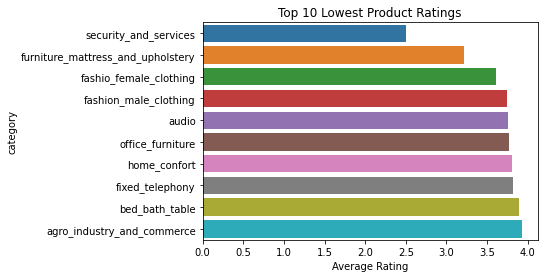

In [9]:
sns.barplot(data = lowest_10_ratings, x = 'review_score', y = lowest_10_ratings.index)
plt.title('Top 10 Lowest Product Ratings')
plt.xlabel('Average Rating')
plt.ylabel('category');

In [10]:
highest_share_of_one_star = products_categories.sort_values('share_of_one_stars', ascending = False).nlargest(10,'share_of_one_stars')

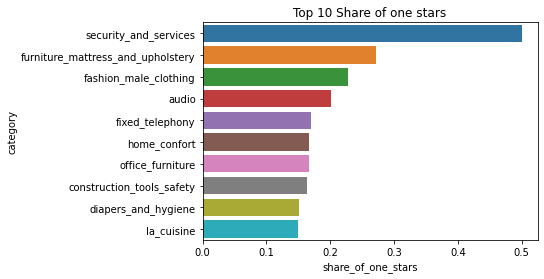

In [11]:
sns.barplot(data = highest_share_of_one_star, x = 'share_of_one_stars', y = highest_share_of_one_star.index)
plt.title('Top 10 Share of one stars')
plt.xlabel('share_of_one_stars')
plt.ylabel('category');

# Second approach: Removing worst performing product categories

In [12]:
orders = Order().get_training_data()[['order_id', 'review_score']]
orders['cost'] = orders['review_score'].map({1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
data = Olist().get_data()
products = Product().get_training_data()
oc = data['order_items'][['order_id', 'product_id']].drop_duplicates(subset=['order_id', 'product_id'])
category_reviews = orders[['order_id', 'cost']].merge(oc, on='order_id').merge(products, on='product_id')
category_cost = category_reviews.groupby('category')['cost'].sum().reset_index()
products_categories = products_categories.merge(category_cost, on='category')

## Lowest profit categories

In [13]:
products_categories['revenue'] = products_categories.sales * 0.1
products_categories['profit'] = products_categories.revenue - products_categories.cost
products_categories.sort_values('profit', ascending = True)
lowest_profit_categories = products_categories.sort_values('profit', ascending = False).nsmallest(10,'profit')

In [14]:
lowest_profit_categories[['category', 'n_orders', 'sales', 'cost', 'revenue', 'profit']]

,category,n_orders,sales,cost,revenue,profit
7,bed_bath_table,10101,1030834.98,195300,103083.498,-92216.502
39,furniture_decor,6699,718171.91,118590,71817.191,-46772.809
68,telephony,4256,318839.15,69730,31883.915,-37846.085
15,computers_accessories,6840,899465.74,114040,89946.574,-24093.426
26,electronics,2555,155703.17,37520,15570.317,-21949.683
49,housewares,5956,623828.14,82750,62382.814,-20367.186
28,fashion_bags_accessories,1957,150576.02,25780,15057.602,-10722.398
57,office_furniture,1293,269728.24,33310,26972.824,-6337.176
6,baby,2899,407673.24,46450,40767.324,-5682.676
65,sports_leisure,7798,976548.15,103100,97654.815,-5445.185


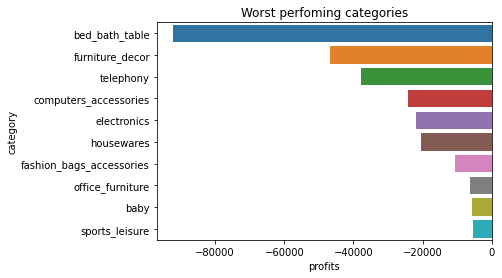

In [15]:
sns.barplot(data = lowest_profit_categories, x = 'profit', y = lowest_profit_categories.category)
plt.title('Worst perfoming categories')
plt.xlabel('profits')
plt.ylabel('category');

### Finnancial cost of removing 10 lowest profit categories

In [16]:
lowest_profit_categories.agg({'profit': 'sum','revenue': 'sum', 'n_orders': 'sum'}).rename({'profit': 'Savings on bad_reviews_costs:', 'revenue': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()

Savings on bad_reviews_costs:   -271433.0
Revenue lost:                    555137.0
Number of orders:                 50354.0
dtype: float64

In [17]:
products_categories['cost vs revenues'] = round((products_categories.cost / products_categories.revenue), 2)

## Worst categories costs vs revenues

In [18]:
worst_performing_categories = products_categories.sort_values('cost vs revenues', ascending = False).nlargest(10,'cost vs revenues')
worst_performing_categories[['category', 'cost','revenue','profit', 'cost vs revenues']]

,category,cost,revenue,profit,cost vs revenues
46,home_comfort_2,530,76.027,-453.973,6.97
61,security_and_services,100,28.329,-71.671,3.53
23,diapers_and_hygiene,460,153.879,-306.121,2.99
30,fashion_male_clothing,2930,1030.723,-1899.277,2.84
27,fashio_female_clothing,730,270.974,-459.026,2.69
35,flowers,280,111.004,-168.996,2.52
26,electronics,37520,15570.317,-21949.683,2.41
3,arts_and_craftmanship,420,181.401,-238.599,2.32
68,telephony,69730,31883.915,-37846.085,2.19
12,christmas_supplies,1840,876.352,-963.648,2.10


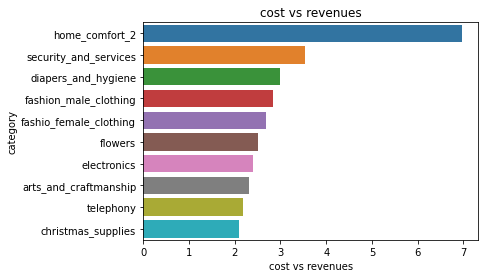

In [19]:
sns.barplot(data = products_categories, x = 'cost vs revenues', y = worst_performing_categories.category)
plt.title('cost vs revenues')
plt.xlabel('cost vs revenues')
plt.ylabel('category');

## Should we, remove categories that are have higher cost vs revenues values?

### Finnancial impact of removing 10 worst performing categories:

In [20]:
ten_wpc_agg = worst_performing_categories.agg({'profit': 'sum','revenue': 'sum', 'n_orders': 'sum'}).rename({'profit': 'Savings on bad_reviews_costs:', 'revenue': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()
ten_wpc_agg

Savings on bad_reviews_costs:   -64357.0
Revenue lost:                    50183.0
Number of orders:                 7198.0
dtype: float64

### Finnancial impact of removing 15 worst performing categories:

In [22]:
fifteen_wpc = products_categories.sort_values('cost vs revenues', ascending = False).nlargest(15,'cost vs revenues')
fifteen_wpc.agg({'profit': 'sum','revenue': 'sum', 'n_orders': 'sum'}).rename({'profit': 'Savings on bad_reviews_costs:', 'revenue': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()

Savings on bad_reviews_costs:   -170524.0
Revenue lost:                    172616.0
Number of orders:                 19864.0
dtype: float64

In [23]:
fifteen_wpc_agg = fifteen_wpc.agg({'profit': 'sum','revenue': 'sum', 'n_orders': 'sum'}).rename({'profit': 'Savings on bad_reviews_costs:', 'revenue': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()

### Finnancial impact of removing 20 worst performing categories:


In [25]:
twenty_wpc = products_categories.sort_values('cost vs revenues', ascending = False).nlargest(20,'cost vs revenues')
twenty_wpc.agg = twenty_wpc.agg({'profit': 'sum','revenue': 'sum', 'n_orders': 'sum'}).rename({'profit': 'Savings on bad_reviews_costs:', 'revenue': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()
twenty_wpc.agg

Savings on bad_reviews_costs:   -226323.0
Revenue lost:                    260297.0
Number of orders:                 27897.0
dtype: float64

In [53]:
worst_performing_sellers = sellers.sort_values('profit_per_seller', ascending = False).nsmallest(50,'profit_per_seller')['seller_id']

In [73]:
monthly_sellers_reviews = Seller().get_monthly_reviews().reset_index()

In [74]:
monthly_sellers_reviews = monthly_sellers_reviews.pivot(index='seller_id', columns='order_approved_at', values='bad_review_cost')

In [75]:
worst_sellers_mr = monthly_sellers_reviews.merge(worst_performing_sellers, on='seller_id').set_index('seller_id')

In [76]:
worst_sellers_mr2 = monthly_sellers_reviews.merge(worst_performing_sellers, on='seller_id').set_index('seller_id')

In [77]:
ly_worst_sellers_mr = worst_sellers_mr.iloc[:,-11:-1]

# Third approach: Removing sellers that are underperforming and not showing signs of improving

## Worst sellers reviews by month

## DataFrame showing the costs of bad reviews by seller and month

In [78]:
worst_sellers_mr.iloc[:,-11:-1].head(5)

,2017-11-30 00:00:00,2017-12-31 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-31 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00
seller_id,,,,,,,,,,
06a2c3af7b3aee5d69171b0e14f0ee87,NaN,NaN,40.0,240.0,1110.0,590.0,2110.0,690.0,1750.0,660.0
1025f0e2d44d7041d6cf58b6550e0bfa,3200.0,180.0,1120.0,1280.0,2440.0,1560.0,2190.0,1630.0,530.0,1400.0
128639473a139ac0f3e5f5ade55873a5,730.0,470.0,1160.0,1280.0,1030.0,340.0,210.0,0.0,40.0,40.0
16090f2ca825584b5a147ab24aa30c86,0.0,330.0,130.0,710.0,780.0,780.0,620.0,490.0,930.0,890.0
1835b56ce799e6a4dc4eddc053f04066,2050.0,630.0,1450.0,1880.0,1120.0,1020.0,420.0,580.0,380.0,570.0


## These graphs show the bad_review_costs of two example sellers in the last 6 months

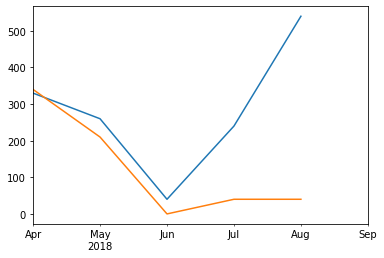

In [79]:
worst_sellers_mr.iloc[10, 18:].plot()
worst_sellers_mr.iloc[2, 18:].plot();

You can notice that one seller cost of bad reviews is decreasing over the last 6 months, and the other is increasing.

In [80]:
worst_sellers_mr["last 3 months costs"] = worst_sellers_mr.iloc[:,-4:-1].sum(axis=1)
worst_sellers_mr["6-3 months costs"] = worst_sellers_mr.iloc[:,-7:-4].sum(axis=1)

In [83]:
worst_sellers_mr["Improvement"] =  worst_sellers_mr["6-3 months costs"] - worst_sellers_mr["last 3 months costs"]

In [85]:
worst_sellers_mr.reset_index(inplace=True)

## Sellers that in the last 3 months performed worse than in the 3 months before

In [86]:
worst_sellers_mr.sort_values('Improvement', ascending = True)[['seller_id', '6-3 months costs', 'last 3 months costs', "Improvement"]].head(10)

,seller_id,6-3 months costs,last 3 months costs,Improvement
20,6560211a19b47992c3666cc44a7e94c0,6000.0,10640.0,-4640.0
48,f46490624488d3ff7ce78613913a7711,1470.0,2380.0,-910.0
26,85d9eb9ddc5d00ca9336a2219c97bb13,580.0,1030.0,-450.0
3,16090f2ca825584b5a147ab24aa30c86,1890.0,2310.0,-420.0
18,53e4c6e0f4312d4d2107a8c9cddf45cd,1120.0,1470.0,-350.0
10,2138ccb85b11a4ec1e37afbd1c8eda1f,630.0,820.0,-190.0
21,7040e82f899a04d1b434b795a43b4617,1130.0,1250.0,-120.0
31,8e6d7754bc7e0f22c96d255ebda59eba,0.0,100.0,-100.0
16,4c2b230173bb36f9b240f2b8ac11786e,0.0,90.0,-90.0
27,88460e8ebdecbfecb5f9601833981930,1850.0,1870.0,-20.0


In [87]:
cols = ['Improvement']
worst_sellers_mr[cols] = worst_sellers_mr[worst_sellers_mr[cols] < 0][cols]
worst_sellers_mr.reset_index(inplace = True)
sellers_to_remove = worst_sellers_mr[['seller_id','Improvement']].copy()
sellers_to_remove = sellers_to_remove.dropna()

In [88]:
str_profits = sellers.merge(sellers_to_remove, on='seller_id').set_index('seller_id')

### Finnancial impact of removing sellers that are not improving

Should we, from time to time (maybe each month?) remove sellers that are consistently underperforming and not showing signs of improvement?
Maybe we should notify sellers that are performing worse now than in the months before. After a x number of notifications, we could exclude the seller from Olist

In [89]:
str_profits.agg = str_profits.agg({'profit_per_seller': 'sum','revenue_per_seller': 'sum', 'n_orders': 'sum'}).rename({'profit_per_seller': 'Savings on bad_reviews_costs:', 'revenue_per_seller': 'Revenue lost:', 'n_orders': 'Number of orders:'}).round()
str_profits.agg

Savings on bad_reviews_costs:   -79971.0
Revenue lost:                    43794.0
Number of orders:                 5047.0
dtype: float64

# Conclusion:

With multiple approachs (Removing categories that perform badly compared to the revenues they bring, and removing sellers that are generating high reviews costs and don't show signs of improving their performance) we could obtain better profit margins in the future.